# Statistical model

Importerer pakker

In [9]:
import json
import requests
import pickle
import math
import pandas as pd
import numpy as np
import collections
from pathlib import Path
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

import menon_styles
%load_ext autoreload
%autoreload 2


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option('float_format', '{:.2f}'.format)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Menon-farger

In [10]:
menon_styles.menon_styles()

## Read data

In [5]:
teams = pd.read_pickle(Path('../data/teams.pkl'))
teams.head()

,team_idx,team,games,win
0,0,Afghanistan,103,29.00
1,1,Albania,314,78.00
2,2,Algeria,482,202.00
3,3,American Samoa,42,4.00
4,4,Andorra,146,5.00


In [6]:
df = (pd
      .read_pickle(Path('../data/raw.pkl'))
      .merge(right=teams[['team', 'team_idx']], left_on='home_team', right_on='team')
      .drop('team', axis=1)
      .rename(columns={'team_idx': 'home_team_idx'})
      .merge(right=teams[['team', 'team_idx']], left_on='away_team', right_on='team')
      .drop('team', axis=1)
      .rename(columns={'team_idx': 'away_team_idx'})
      .assign(year=lambda df: df.date.dt.year - df.date.dt.year.min())
     )
df.to_pickle('../data/games_idx.pkl')
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_goals,abs_goal_diff,home_win,away_win,home_team_idx,away_team_idx,year
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,0,0,False,False,181,64,0
1,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,3,1,True,False,181,64,2
2,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,3,3,True,False,181,64,4
3,1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False,9,5,True,False,181,64,6
4,1880-03-13,Scotland,England,5,4,Friendly,Glasgow,Scotland,False,9,1,True,False,181,64,8


In [14]:
n_teams = len(teams)
n_teams

245

## Model

### PyMC Rugby prediction model (constant parameters over time)

Stjeler modell fra https://docs.pymc.io/notebooks/rugby_analytics.html

TODO: Legg mer vekt på nylige kamper. ELO?

In [ ]:
with pm.Model() as constant_model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=2, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=2, sd=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sd=sd_att, shape=n_teams)
    defs_star = pm.Normal("defs_star", mu=0, sd=sd_def, shape=n_teams)

    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[df.home_team_idx.values] + defs[df.away_team_idx.values])
    away_theta = tt.exp(intercept + atts[df.away_team_idx.values] + defs[df.home_team_idx.values])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=df.home_score.values)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=df.away_score.values)

In [ ]:
with constant_model:
    trace = pm.sample(2000, cores=3)
    pm.traceplot(trace)

In [ ]:
Path('../data/pymc_trace.pkl').write_bytes(pickle.dumps({'model': model, 'trace': trace}))

In [8]:
ROOT_DIR = Path(os.environ.get('ROOT_DIR'))
DATA_DIR = ROOT_DIR / 'data'

data = pickle.loads((DATA_DIR / 'processed/pymc_trace.pkl').read_bytes())
_, trace = data['model'], data['trace']


In [27]:
pars = dict(intercept=pm.stats.quantiles(trace['intercept'], qlist = list(range(100))),
            home_advantage=pm.stats.quantiles(trace['home'], qlist = list(range(100))),
            atts=pm.stats.quantiles(trace['atts'], qlist = list(range(100))),
            defs=pm.stats.quantiles(trace['defs'], qlist = list(range(100))))

In [28]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
Path(DATA_DIR / 'processed/pymc_pars.json').write_text(json.dumps(pars, cls=NumpyEncoder))

1026849

### Time-varying coefficients

Dette er litt vanskelig, jobber meg gradvis fremover

In [126]:
included_teams = ['England']#, 'Brazil']
df_tmv = (df
          .copy()
          .query("date.dt.year >= 1980")
          .query("home_team in @included_teams")
          .assign(year = lambda df: df.date.dt.year - df.date.dt.year.min())
          .assign(home_team_idx = lambda df: df.home_team.apply(lambda team: included_teams.index(team)))
          .sort_values(by='date', ascending=True)
         )
df_tmv

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_goals,abs_goal_diff,home_win,away_win,home_team_idx,away_team_idx,year
7325,1980-02-06,England,Ireland,2,0,UEFA Euro qualification,London,England,False,2,2,True,False,0,100,0
10829,1980-05-13,England,Argentina,3,1,Friendly,London,England,False,4,2,True,False,0,8,0
915,1980-05-20,England,Northern Ireland,1,1,British Championship,London,England,False,2,0,False,False,0,157,0
5101,1980-09-10,England,Norway,4,0,FIFA World Cup qualification,London,England,False,4,4,True,False,0,159,0
3222,1980-11-19,England,Switzerland,2,1,FIFA World Cup qualification,London,England,False,3,1,True,False,0,207,0
6591,1981-03-25,England,Spain,1,2,Friendly,London,England,False,3,1,False,True,0,195,1
10111,1981-04-29,England,Romania,0,0,FIFA World Cup qualification,London,England,False,0,0,False,False,0,173,1
8684,1981-05-12,England,Brazil,0,1,Friendly,London,England,False,1,1,False,True,0,28,1
594,1981-05-20,England,Wales,0,0,British Championship,London,England,False,0,0,False,False,0,236,1
17457,1981-05-23,England,Scotland,0,1,British Championship,London,England,False,1,1,False,True,0,181,1


In [130]:
with pm.Model() as time_varying_model:
    num_teams = len(included_teams)
    num_years = df_tmv.year.max() + 1
    
    step_size = pm.HalfNormal('step_size', sd=np.ones(num_teams), shape=num_teams)
    
    atts_star = pm.GaussianRandomWalk('atts_star', sd=step_size, 
                              shape=(num_years, num_teams))
    #defs_star = pm.GaussianRandomWalk('defs_star', sd=step_size, 
    #                          shape=(num_years, num_teams))
    
    #atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star, axis=0))
    #defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star, axis=0))
    
    home_theta = tt.exp(atts_star[df_tmv.year.values])
    #away_theta = tt.exp(defs_star[df_tmv.year.values, df_tmv.home_team_idx.values])
    

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=df_tmv.home_score.values)
    #away_points = pm.Poisson('away_points', mu=away_theta, observed=df_tmv.away_score.values)

In [143]:
step_size = pm.HalfNormal.dist(sd=np.ones(num_teams), shape=num_teams)
print("num_teams:", num_teams)
print("shape of step_size:", step_size.shape)
step_size.random()

num_teams: 1
shape of step_size: [1]


array([0.05630456])

In [150]:
atts_star = pm.GaussianRandomWalk.dist(sd=1, 
                              shape=(num_years, num_teams))
print(atts_star.shape)
print(atts_star.testval)

[39  1]
None


In [131]:
with time_varying_model:
    trace = pm.sample(200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/kristomi/.pyenv/versions/3.6.4/envs/default/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atts_star, step_size_log__]
100%|██████████| 700/700 [06:59<00:00,  1.67it/s]
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
Only 200 samples in chain.
The acceptance probability does not match the target. It is 0.009968289993907191, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
Only 200 samples i

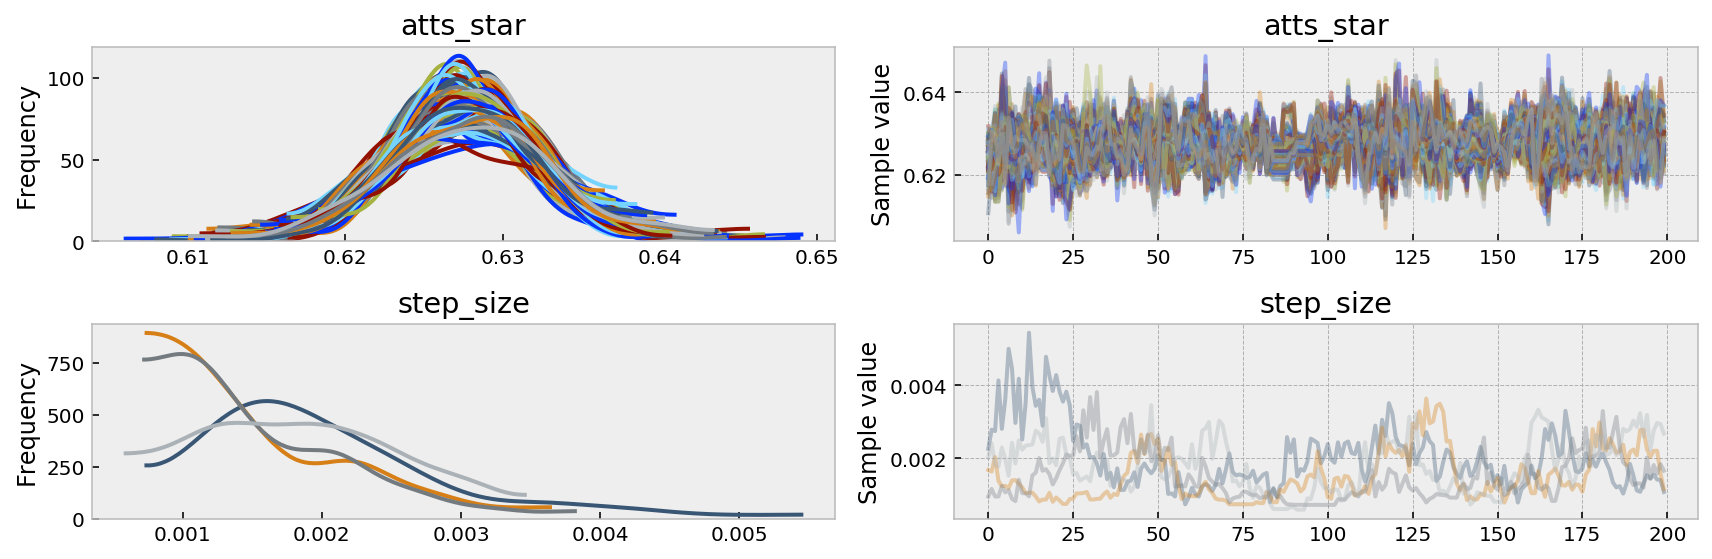

In [129]:
pm.traceplot(trace);

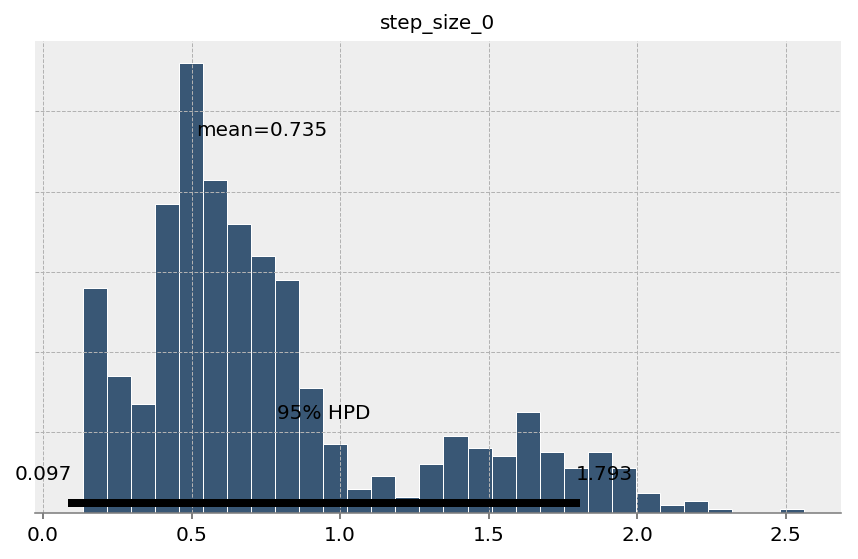

In [114]:
pm.plot_posterior(trace, ['step_size']);

In [68]:
trace['atts_star'].shape

(8000, 146, 2)

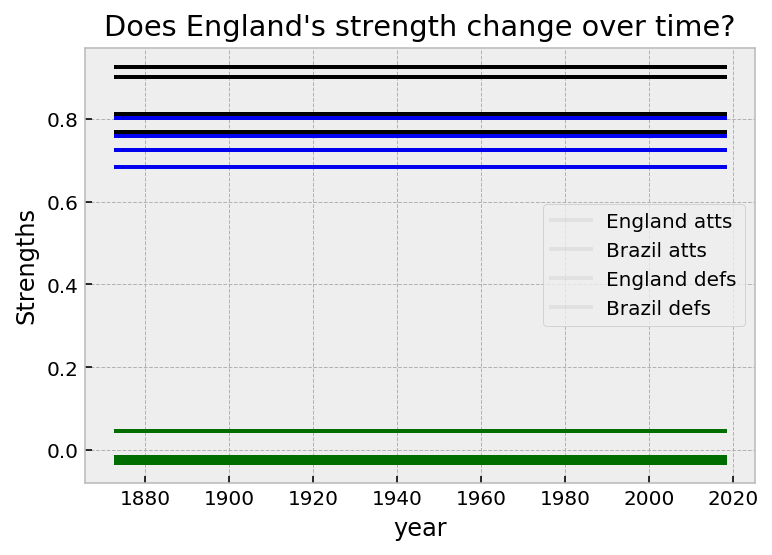

In [69]:
years = range(df_tmv.date.dt.year.min(), df_tmv.date.dt.year.max()+1)
plt.plot(years, trace['atts_star'][:,:,0].T, alpha=.05, color='k');
plt.plot(years, trace['atts_star'][:,:,1].T, alpha=.05, color='b');
plt.plot(years, trace['defs_star'][:,:,0].T, alpha=.05, color='r');
plt.plot(years, trace['defs_star'][:,:,0].T, alpha=.05, color='g');
plt.legend(['England atts', 'Brazil atts', 'England defs', 'Brazil defs'])
plt.xticks = years
plt.xlabel('year'); plt.ylabel('Strengths'); plt.title("Does England's strength change over time?");

### Elo (world football Elo)

https://www.eloratings.net/about

In [383]:
class TeamElo:
    """
    Elo based predictions. Based off of
    - Fivethirtyeight: https://github.com/fivethirtyeight/nfl-elo-game/blob/master/forecast.py
    - World Football Elo ratings: https://www.eloratings.net/about
    - This academic prediction paper: http://www.collective-behavior.com/publ/ELO.pdf
    """
    def __init__(self, team):
        self.team = team
        self.elos = []
        self.last_elo = 1500.0

    
    def add_elo(self, date, change):
        self.elos.append({'team': self.team,
                          'date': date,
                          'elo': self.last_elo,
                          'elo_new': self.last_elo + change})
        self.last_elo += change
        
    
    @property
    def df(self):
        return pd.DataFrame(self.elos).sort_values(by='date', ascending=True)
    
    
    def plot(self):
        df = self.df
        ax = df.plot(x='date', y='elo')
        return ax
    
class Elo:
    def __init__(self):
        """
        Class for generating Elo scores and predicting game outcomes. Has to be trained with a games df
        """
        teams = {}
        unique_teams = set(df.home_team.values) | set(df.away_team.values)
        for team in unique_teams:
            teams[team] = TeamElo(team)
            
        self.teams = teams
        self.HFA = 100.0    # Home field advantage 
        self.K = 20.0       # The speed at which Elo ratings change
        
        self.lr = LogisticRegression() # Logistic regression for predicting outcome of games



        
    def train(self, df):
        """ Generates win probabilities and estimates Elo scores for each country """
    
        games = df.sort_values(by='date', ascending=True).to_dict(orient='index')

        


        for _, game in games.items():
            home_team, away_team = game['home_team'], game['away_team']
            
            out = self.update(date=game['date'],
                              home_team=game['home_team'],
                              away_team=game['away_team'],
                              home_score=game['home_score'],
                              away_score=game['away_score'],
                              neutral=game['neutral']
                             )

            game['home_elo'], game['away_elo'], game['elo_home_win_prob'] = out['home_elo'], out['away_elo'], out['p_home']

        out = pd.DataFrame(games).T
        out['draw'] = 1-out['home_win'] - out['away_win']
        X = (out['home_elo'] - out['away_elo']).values
        y = out[['home_win', 'draw', 'away_win']].astype(int).values
        
        lr.fit(X.reshape(-1, 1), np.argwhere(y==1)[:,1])

        return out
    
    def __call__(self, )
    
    def predict_update(self, home_team, away_team, date=None, neutral=True, can_draw=True):
        winner = self.pred(home_team, away_team, neutral, can_draw)
        if winner == home_team:
            home_score, away_score = 1, 0
        elif winner == away_team:
            home_score, away_score = 0, 1
        else:
            home_score, away_score = 0, 0
        
        self.update(date, home_team, away_team, home_score, away_score, neutral)
    
    
    def update(self, date, home_team, away_team, home_score, away_score, neutral):
        home_elo, away_elo = self.teams[home_team].last_elo, self.teams[away_team].last_elo
        p_home = self._predict_from_elo(home_elo, away_elo, neutral)
        shift = self.elo_change(home_score - away_score, p_home)

        self.teams[home_team].add_elo(date, shift)
        self.teams[away_team].add_elo(date, -shift)
        
        return {'home_elo': home_elo, 'away_elo': away_elo, 'p_home': p_home}
        
    

    def pred(self, home_team, away_team, neutral=True, can_draw=True):
        home_elo, away_elo = self.teams[home_team].last_elo, self.teams[away_team].last_elo
        ar = lr.predict_proba(home_elo - away_elo)
        outcome = [home_team, 'draw', away_team][np.argmax(np.random.random() < ar.cumsum())]
        if outcome == 'draw' and can_draw == False:
            return self.pred(home_team, away_team, neutral, can_draw)
        return outcome        

    
    @property
    def teams_df(self):
        teams = (pd
                 .DataFrame
                 .from_records([val for team in teams.values() for val in self.team.elos])
                 .sort_values(by=['team', 'date'], ascending=[True, True])
                 .reset_index()
                )
        return teams

    
    def _predict_from_elo(self, home_elo, away_elo, neutral=True):
        """
        Given two teams, will predict probability for home win
        """
        elo_diff = home_elo - away_elo + (0 if neutral == 1 else self.HFA)

        p_home = 1.0 / (math.pow(10.0, (-elo_diff/400.0)) + 1.0)
        
        return p_home
    

    def elo_change(self, score_diff, estimated_p_home):
        if abs(score_diff) == 1:
            mult = 1
        elif abs(score_diff) == 2:
            mult = 1.5
        elif abs(score_diff) == 3:
            mult = 1.75
        else:
            mult = 1+ (abs(score_diff)-3)/8

        if score_diff == 0:
            result = .5
        elif score_diff > 0:
            result = 1
        else:
            result = 0

        # Elo shift based on K and the margin of victory multiplier
        shift = (self.K * mult) * (result - estimated_p_home)
        
        return shift





In [382]:
elo = Elo()
elo_teams = elo.train(df)
Path('../data/elo_pickle.pkl').write_bytes(pickle.dumps(elo))

4257322

In [288]:
elo = pickle.loads(Path('../data/elo_pickle.pkl').read_bytes())

In [380]:
elo.pred('Brazil', 'Norway', can_draw=False)

'Home'

In [302]:
elo_teams

,abs_goal_diff,away_elo,away_score,away_team,away_team_idx,away_win,city,country,date,elo_home_win_prob,home_elo,home_score,home_team,home_team_idx,home_win,neutral,total_goals,tournament,year
0,0,1500.00,0,England,64,False,Glasgow,Scotland,1872-11-30 00:00:00,0.64,1500.00,0,Scotland,181,False,False,0,Friendly,0
1,1,1512.41,1,England,64,False,Glasgow,Scotland,1874-03-07 00:00:00,0.61,1487.59,2,Scotland,181,True,False,3,Friendly,2
2,3,1502.64,0,England,64,False,Glasgow,Scotland,1876-03-04 00:00:00,0.63,1497.36,3,Scotland,181,True,False,3,Friendly,4
3,5,1471.74,2,England,64,False,Glasgow,Scotland,1878-03-02 00:00:00,0.74,1553.46,7,Scotland,181,True,False,9,Friendly,6
4,1,1482.35,4,England,64,False,Glasgow,Scotland,1880-03-13 00:00:00,0.75,1576.51,5,Scotland,181,True,False,9,Friendly,8
5,4,1493.68,1,England,64,False,Glasgow,Scotland,1882-03-11 00:00:00,0.77,1607.19,5,Scotland,181,True,False,6,Friendly,10
6,1,1501.25,0,England,64,False,Glasgow,Scotland,1884-03-15 00:00:00,0.81,1648.75,1,Scotland,181,True,False,1,British Championship,12
7,0,1524.31,1,England,64,False,Glasgow,Scotland,1886-03-27 00:00:00,0.81,1675.04,1,Scotland,181,False,False,2,British Championship,14
8,5,1548.41,5,England,64,True,Glasgow,Scotland,1888-03-17 00:00:00,0.81,1697.29,0,Scotland,181,False,False,5,British Championship,16
9,0,1596.53,1,England,64,False,Glasgow,Scotland,1890-04-05 00:00:00,0.77,1704.25,1,Scotland,181,False,False,2,British Championship,18


### Posterior predictive check

In [ ]:
data = pickle.loads(Path('../data/pymc_trace.pkl').read_bytes())
model, trace = data['model'], data['trace']

In [ ]:
with model:
    pp_trace = pm.sample_ppc(trace)

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in pp_trace['home_points']], bins=19, alpha=0.5)
ax.axvline(df.home_score.values.mean())
ax.set(title='Posterior predictive of mean home goals', xlabel='mean home goals', ylabel='Frequency');

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in pp_trace['away_points']], bins=19, alpha=0.5)
ax.axvline(df.away_score.values.mean())
ax.set(title='Posterior predictive of mean away goals', xlabel='mean away goals', ylabel='Frequency');

### Model outputs

In [ ]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['atts']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['atts'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = (df_hpd
          .join(df_median)
          .assign(relative_lower=lambda df: df.hpd_median - df.hpd_low)
          .assign(relative_upper=lambda df: df.hpd_high - df.hpd_median)
          .assign(country=lambda df: df.index)
          .sort_values(by='hpd_median')
          .reset_index(drop=True)
          .merge(right=teams[['team', 'games', 'win']], left_on='country', right_on='team').drop('team', axis=1)
         )


In [ ]:
groups = json.loads(Path('../data/groups.json').read_text())
groups = [el for group in groups.values() for el in group]
df = (df_hpd
      .query('country in @groups')
      .sort_values(by='hpd_median')
      .reset_index(drop=True)
     )

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
axs.errorbar(df.hpd_median, df.index,
             xerr=(df[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_ylabel('Team')
axs.set_xlabel('Posterior Attack Strength')
_= axs.set_yticks(df.index)
_= axs.set_yticklabels(df.country, rotation=45)

### Prediction, if needed

https://discourse.pymc.io/t/prediction-using-sample-ppc-in-hierarchical-model/116
https://github.com/pymc-devs/pymc3/issues/1001
